# Анализ товарного ассортимента
---

## Контекст

Интернет-магазин товаров для дома «Пока все ещё тут» нуждается в анализе товарного ассортимента.
Нам предстоит помочь ему в этой задаче, а именно: 

> - Предобработать данные(пропуски, дубликаты, аномалии, тип данных);
> - Выделить информацию о дате в отдельные столбцы(год, месяц, день, день недели, квартал, час);
> - Выделить товарные категории;
> - Провести **сегментацию товаров** по группам **(ABC/XYZ-анализ)**;
> - Посмотреть на распределение количества и суммы продаж за (год, месяц, день, день недели, квартал, час) в разбивке по товарным категориям;
> - Посмотреть на распределение количества и суммы продаж (год, месяц, день, день недели, квартал, час) в разбивке по товарным сегментам;
> - Проверить влияет ли **фактор сезонности** на финансовые показатели товаров;
> - Cформулировать и проверить две статистические гипотезы;
> - Сформировать **общий вывод и рекомендации** для отделов закупок и маркетинга.

## Описание данных
---

Датасет содержит информацию о транзакциях интернет-магазина товаров для дома и быта «Пока все ещё тут».

Колонки в ecommerce_dataset.csv :

 * `date` — дата заказа;
 * `customer_id` — идентификатор покупателя;
 * `order_id` — идентификатор заказа;
 * `product` — наименование товара;
 * `quantity` — количество товара в заказе;
 * `price` — цена товара.

## Импорт библиотек и загрузка данных

Импортируем библиотеки

In [593]:
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta

import plotly.express as px 
import plotly.io as pio


import pymorphy2
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

import warnings
warnings.filterwarnings('ignore')  

Загружаем данные

In [594]:
try:
     sessions = pd.read_csv('/datasets/ecommerce_dataset.csv', parse_dates=['date'])
except:
     sessions = pd.read_csv('/Users/ivan_miroshnichenko/Downloads/datasets/ecommerce_dataset.csv', parse_dates=['date'])

## Предобработка данных

In [595]:
display(sessions.head(20))
display(sessions.info())

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0
5,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Шеффлера Лузеана d-9 см,1,164.0
6,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Юкка нитчатая d-12 см h-25-35 см,1,134.0
7,2018100108,375e0724-f033-4c76-b579-84969cf38ee2,68479,Настенная сушилка для белья Gimi Brio Super 100,1,824.0
8,2018100108,6644e5b4-9934-4863-9778-aaa125207701,68478,"Таз пластмассовый 21,0 л круглый ""Водолей"" С61...",1,269.0
9,2018100109,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beig...,1,674.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   object 
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 315.9+ KB


None

Видим, что количество значений в каждой колонке одинаковое, значит пропусков нет. Проверим дубликаты.

In [596]:
sessions.duplicated().sum()

0

Дубликатов также необнаружено.

Добавим данные о месяце, годе, дне, дне недели, квартале и часе транзакции.

In [597]:
sessions['date'] = pd.to_datetime(sessions['date'], format = '%Y%m%d%H')
sessions['month'] = sessions['date'].astype('datetime64[M]')
sessions['year'] = sessions['date'].astype('datetime64[Y]')
sessions['day'] = sessions['date'].astype('datetime64[D]')
sessions['day_of_week'] = sessions['date'].dt.day_name()
sessions['quarter'] = sessions['date'].dt.quarter
sessions['hour'] = sessions['date'].dt.hour

Посчитаем `revenue` по каждому событию.

In [598]:
sessions['revenue'] = sessions['quantity'] * sessions['price']

Нам нужно проверить нет ли в датасете задвоеных заказов. Они могут появляться из-за технических сбоев в системе обработки платежей и исказят нам общую картину.

In [599]:
unique_orders = sessions.groupby('order_id').agg({'customer_id': 'nunique', 'revenue': 'sum', 'quantity': 'sum'}).reset_index()
display(unique_orders.query('customer_id > 1'))
print('Количество задвоенных заказов:',unique_orders.query('customer_id > 1')['order_id'].count())

,order_id,customer_id,revenue,quantity
248,14872,2,1122.0,12
516,68785,2,748.0,2
797,69283,2,328.0,2
817,69310,2,1652.0,28
832,69345,2,1948.0,2
862,69410,2,132.0,6
902,69485,3,3635.0,3
933,69531,2,49668.0,12
1066,69833,2,1196.0,4
1200,70114,2,2400.0,60


Количество задвоенных заказов: 29


Удалим задвоенные данные, оставив последнюю дату и самое позднее время этого заказа.

In [600]:
sessions = sessions.drop_duplicates(
    subset=['customer_id', 'order_id', 'product'], keep='last').reset_index()

In [601]:
sessions = sessions.drop_duplicates(
    subset=['order_id', 'product', 'quantity']).reset_index()

In [602]:
unique_orders = sessions.groupby('order_id').agg({'customer_id': 'nunique', 'revenue': 'sum', 'quantity': 'sum'}).reset_index()
display(unique_orders.query('customer_id > 1'))

,order_id,customer_id,revenue,quantity
902,69485,2,2361.0,2


Остался один задвоенный заказ. 

In [603]:
sessions.query('order_id == 69485')

,level_0,index,date,customer_id,order_id,product,quantity,price,month,year,day,day_of_week,quarter,hour,revenue
1113,1117,1282,2018-12-20 16:00:00,5be0f4b4-947f-4672-b147-73ef5936ecd4,69485,Набор столовых приборов 24 предмета SAINT GERM...,1,1087.0,2018-12-01,2018-01-01,2018-12-20,Thursday,4,16,1087.0
1122,1126,1292,2018-12-21 11:00:00,266beb08-ec9b-43b4-89bb-ac60fa23ffee,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0,2018-12-01,2018-01-01,2018-12-21,Friday,4,11,1274.0


In [604]:
sessions = sessions.query('index != 1282')

In [605]:
sessions.drop(columns = ['level_0', 'index'], inplace=True) 

In [606]:
sessions

,date,customer_id,order_id,product,quantity,price,month,year,day,day_of_week,quarter,hour,revenue
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,2018-10-01,2018-01-01,2018-10-01,Monday,4,0,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,2018-10-01,2018-01-01,2018-10-01,Monday,4,0,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2018-10-01,2018-01-01,2018-10-01,Monday,4,0,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,2018-10-01,2018-01-01,2018-10-01,Monday,4,0,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2018-10-01,2018-01-01,2018-10-01,Monday,4,0,112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4812,2019-10-31 11:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73156,"Таз пластмассовый 40,0 л пищевой овальный (Иж)...",1,404.0,2019-10-01,2019-01-01,2019-10-31,Thursday,4,11,404.0
4813,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,2019-10-01,2019-01-01,2019-10-31,Thursday,4,12,1087.0
4814,2019-10-31 13:00:00,25df96a7-c453-4708-9cea-a3dfc7c342ea,73162,Герань домашняя (пеларгония зональная) цветуща...,1,157.0,2019-10-01,2019-01-01,2019-10-31,Thursday,4,13,157.0
4815,2019-10-31 14:00:00,73d1cd35-5e5f-4629-8cf2-3fda829d4e58,73164,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0,2019-10-01,2019-01-01,2019-10-31,Thursday,4,14,397.0


Взглянем на выбросы по количеству заказов

In [607]:
# зададим параметры по умолчанию для plotly express

pio.templates.default = "simple_white" 

px.defaults.template = "seaborn"
px.defaults.color_continuous_scale = px.colors.sequential.Blackbody
pio.renderers.default='colab'
px.defaults.width = 1400
px.defaults.height = 1000

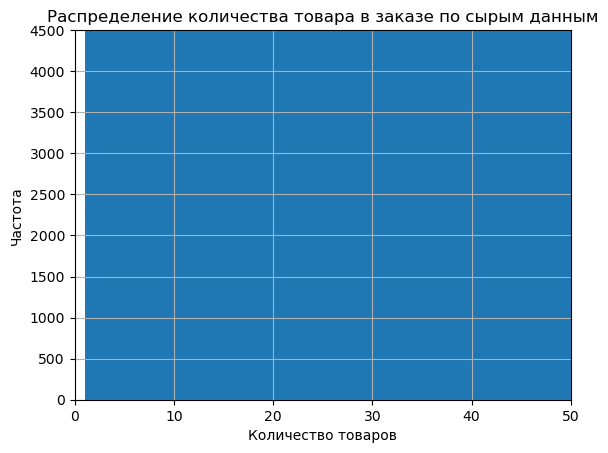

99-й перцентиль для количества товара в заказе: 30 
Количество строк с аномальными значениями: 38 строк
Доля аномальных значений от общего количества записей: 0.8%


In [608]:
sessions['quantity'].hist()
plt.xlabel('Количество товаров')
plt.ylabel('Частота')
plt.title(r'Распределение количества товара в заказе по сырым данным')
plt.xlim(0,50)
plt.ylim(0,4500)
plt.grid(True)
plt.show()


upper_limit_quantity = sessions['quantity'].quantile(.99) 
print('99-й перцентиль для количества товара в заказе: {:.0f} '.format(upper_limit_quantity))


upper_limit_count = sessions[sessions['quantity'] > upper_limit_quantity]['quantity'].count()
print('Количество строк с аномальными значениями: {} строк'.format(upper_limit_count))
print('Доля аномальных значений от общего количества записей: {:.1%}'.format(upper_limit_count / len(sessions))) 

Удалим аномальные значения 

In [609]:
sessions = sessions.query('quantity < @upper_limit_quantity')

## EDA

### Сегментация товаров ABC

Проведем ABC-анализ, чтобы выделить товары, а затем и категории товаров, которые приносят основной доход для компании.

In [610]:
abc_class = sessions.groupby('product').agg({'quantity':'sum', 'revenue':'sum'}).sort_values(by=['revenue'], ascending=False)

Выделим сводную таблицу с наименованиями продуктов, количеством проданных товаров и выручкой с продаж. Отсротируем таблицу в порядке убывания выручки, это крайне важно для подсчета куммулятивной суммы и возрастающего процента.

In [611]:
abc_class

,quantity,revenue
product,,
Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,30,53232.0
Сумка-тележка 2-х колесная Gimi Argo синяя,47,50405.0
"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",5,28045.0
"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",5,24370.0
"Веник сорго с деревянной ручкой с 4-мя швами, Rozenbal, R206204",37,20010.0
...,...,...
"Цинния Коралловая красавица 0,2 г 4660010773323",1,10.0
Петрушка Итальянский гигант 2 г 4660010776553,1,10.0
"Цинния Оранжевый король 0,5 г 4660010770520",1,10.0


Рассчитаем куммулятивную сумму, она понадобится для определения вклада каждого товара в общую выручку.

In [612]:
abc_class['revenue_cumsum'] = abc_class['revenue'].cumsum()

In [613]:
abc_class

,quantity,revenue,revenue_cumsum
product,,,
Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,30,53232.0,53232.0
Сумка-тележка 2-х колесная Gimi Argo синяя,47,50405.0,103637.0
"Сумка-тележка хозяйственная Andersen Scala Shopper Plus, Lini, синяя 133-108-90",5,28045.0,131682.0
"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",5,24370.0,156052.0
"Веник сорго с деревянной ручкой с 4-мя швами, Rozenbal, R206204",37,20010.0,176062.0
...,...,...,...
"Цинния Коралловая красавица 0,2 г 4660010773323",1,10.0,3151998.0
Петрушка Итальянский гигант 2 г 4660010776553,1,10.0,3152008.0
"Цинния Оранжевый король 0,5 г 4660010770520",1,10.0,3152018.0


Рассчитаем общую сумму продаж всех товаров.

In [614]:
abc_class['revenue_total'] = abc_class['revenue'].sum()

Рассчитаем возрастающий процент, который будет показывать какую долю выручки от общей выручки представляет каждый товар. 

In [615]:
abc_class['revenue_running_percentage'] = (abc_class['revenue_cumsum']/abc_class['revenue_total'] ) *100

Присвоем каждому продукту класс, исходя из принципа Парето : продукты, которые принесли нам 80% выручки - будут группа А, группа В - те, кто принес еще 15% выручки, и группа С - оставшиеся 5%.

In [616]:
def classify_product(percentage): 
    if percentage > 0 and percentage <= 80:
        return 'A'
    elif percentage > 80 and percentage <= 95:
        return 'B'
    else:
        return 'C'

In [617]:
abc_class['ABC_class'] = abc_class['revenue_running_percentage'].apply(classify_product)
abc_class['ABC_rank'] = abc_class['revenue_running_percentage'].rank().astype(int)


In [618]:
abc_class = abc_class.reset_index().sort_values(['ABC_class','ABC_rank'])

Взглянем на показатель общей выручки для каждого класса, а так же на количество продуктов в каждом классе.

In [619]:
print('Выручка для класса A(80%):', abc_class.query('ABC_class == "A"')['revenue'].sum())
print('Выручка для класса B(15%):', abc_class.query('ABC_class == "B"')['revenue'].sum())
print('Выручка для класса C(5%):', abc_class.query('ABC_class == "C"')['revenue'].sum(), '\n')
print('Количество товаров по классам:\n\n',abc_class['ABC_class'].value_counts() )


Выручка для класса A(80%): 2521552.0
Выручка для класса B(15%): 472772.0
Выручка для класса C(5%): 157712.0 

Количество товаров по классам:

 C    984
B    683
A    651
Name: ABC_class, dtype: int64


Видим, что класс А и класс В схожи по размерам, класс С превышает их размер на 30%.

В дальнейшем, когда мы сформируем товарные категории, взглянем на то, как каждый из классов представлен в товарных категориях.

### Сегментация товаров XYZ

XYZ-анализ распределяет товары в зависимости от стабильности спроса. Данный анализ позволит нам рассмотреть спрос на товары не только с точки зрения объема выручки, как АВС, но и частоты.

Создадим сводную таблицу, где индексами будут названия товаров, столбцами будут месяцы, а значения в полях - факт покупки товара в конкретном месяце.

In [620]:
xyz_class = sessions.pivot_table(index='product', columns='month', values='quantity', aggfunc={'quantity':'sum'}).fillna(0)


Рассчитаем стандартное отклонение для количества продаж по месяцам.

In [621]:
xyz_class['std'] = xyz_class.std(axis=1)

Рассчитаем рассчитаем общее количество продаж по месяцам.

In [622]:
xyz_class['total'] = xyz_class.sum(axis=1) - xyz_class['std']

Рассчитаем среднее для количества продаж по месяцам.

In [623]:
xyz_class['avg'] = xyz_class['total'] / (len(xyz_class.columns) -2)

Рассчитаем коэффицент ковариации. Чем меньше коэффициент вариации, тем стабильнее спрос на товар.

In [624]:
xyz_class['cov_coef'] = xyz_class['std'] / xyz_class['avg']

In [625]:
xyz_class = xyz_class.sort_values(by='cov_coef', ascending=False).reset_index()

Взглянем на распределение коэффицента ковариации.

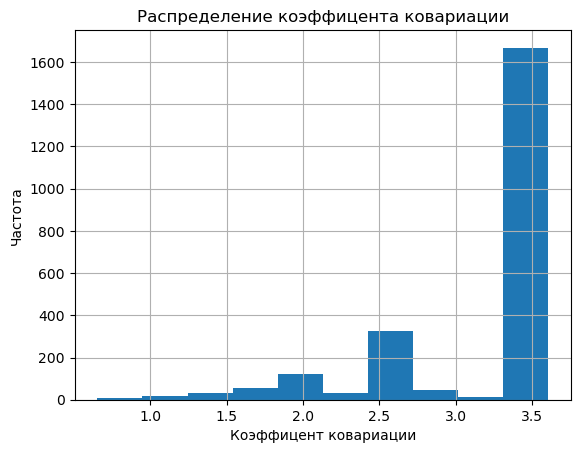

In [626]:
xyz_class['cov_coef'].hist()
plt.xlabel('Коэффицент ковариации')
plt.ylabel('Частота')
plt.title(r'Распределение коэффицента ковариации')
plt.grid(True)

plt.show()

Видим, что у подавляющего числа товаров очень высокий коэффицент ковариации.

Зная коэффициент ковариации по каждому товару, можно разбить их на группы:

> - Группа Х — стабильный спрос, объем продаж от месяца к месяцу почти не изменяются: коэфф.ковар. < 1.
> - Группа Y — условно стабильный спрос, т. е. объемы продаж меняются, но без резких скачков: 1,5 > коэфф.ковар. > 1.
> - Группа Z — спрос нестабилен, покупатели приобретают товар от случая к случаю: коэфф.ковар. > 1,5.

In [627]:
def xyz_classify_product(cov):
    if cov <= 1:
        return 'X'
    elif cov > 1.0 and cov <= 1.5:
        return 'Y'
    else:
        return 'Z'

In [628]:
xyz_class['XYZ_class'] = xyz_class['cov_coef'].apply(xyz_classify_product)

In [629]:
xyz_class

month,product,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,std,total,avg,cov_coef,XYZ_class
0,"Таз пластмассовый 4,5 л пищевой ""Космея"" (Анго...",0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.984604,36.0,2.769231,3.605551,Z
1,"Ложка чайная RIPPLE сталь 2,5 мм, 3 шт, Attrib...",9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.496151,9.0,0.692308,3.605551,Z
2,"Ложка столовая RIPPLE сталь 3 мм, 3 шт, Attrib...",9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.496151,9.0,0.692308,3.605551,Z
3,Вешалка для блузок 41 см черный Attribute AHM791,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.496151,9.0,0.692308,3.605551,Z
4,Новогоднее дерево Ель сербская d-21 см h-60 см,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.496151,9.0,0.692308,3.605551,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2313,Тележка багажная DELTA ТБР-20 синий грузоподъе...,1.0,2.0,1.0,0.0,3.0,1.0,2.0,1.0,3.0,2.0,0.0,0.0,0.0,1.091928,16.0,1.230769,0.887192,X
2314,Пеларгония розебудная Queen Ingrid укорененный...,0.0,0.0,0.0,0.0,3.0,5.0,7.0,4.0,2.0,5.0,6.0,1.0,5.0,2.564551,38.0,2.923077,0.877346,X
2315,Пеларгония зональная диам. 12 см сиреневый пол...,7.0,7.0,0.0,3.0,3.0,5.0,14.0,9.0,6.0,5.0,1.0,2.0,1.0,3.869672,63.0,4.846154,0.798504,X
2316,Сумка-тележка 2-х колесная Gimi Argo синяя,4.0,1.0,10.0,3.0,3.0,3.0,4.0,2.0,1.0,2.0,6.0,3.0,5.0,2.399252,47.0,3.615385,0.663623,X


In [630]:
print('Cреднее количество продаж в месяц для класса X:', round(xyz_class.query('XYZ_class == "X"').groupby('XYZ_class')['total'].mean()))
print('Cреднее количество продаж в месяц для класса Y:', round(xyz_class.query('XYZ_class == "Y"').groupby('XYZ_class')['total'].mean()))
print('Cреднее количество продаж в месяц для класса Z:', round(xyz_class.query('XYZ_class == "Z"').groupby('XYZ_class')['total'].mean()))
print('Количество товаров по классам:\n',xyz_class['XYZ_class'].value_counts() )


Cреднее количество продаж в месяц для класса X: XYZ_class
X    32.0
Name: total, dtype: float64
Cреднее количество продаж в месяц для класса Y: XYZ_class
Y    15.0
Name: total, dtype: float64
Cреднее количество продаж в месяц для класса Z: XYZ_class
Z    3.0
Name: total, dtype: float64
Количество товаров по классам:
 Z    2263
Y      45
X      10
Name: XYZ_class, dtype: int64


### Выделение товарных категорий

Выделим товарные категории, на основе наиболее часто встречающихся лемм продуктов.

In [631]:

punctuation_marks = ['!','?','(',')','-','[',']','{','}',';',':','','/','<','>','.','%']
stop_words = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()    

unique_product = sessions['product'].unique() 
string = ' '.join(unique_product)
tokens = word_tokenize(string.lower())
preprocessed_text = []
for token in tokens:
    if token not in punctuation_marks:
        lemma = morph.parse(token)[0].normal_form
        if lemma not in stop_words:
            preprocessed_text.append(lemma)



In [632]:
display(preprocessed_text)

['комнатный',
 'растение',
 'горшок',
 'алый',
 'вера',
 ',',
 'd12',
 ',',
 'h30',
 'комнатный',
 'растение',
 'горшок',
 'кофе',
 'арабика',
 ',',
 'd12',
 ',',
 'h25',
 'радермахер',
 'd-12',
 'смотреть',
 'h-20',
 'смотреть',
 'хризолидокарпус',
 'лутесценс',
 'd-9',
 'смотреть',
 'циперус',
 'зумул',
 'd-12',
 'смотреть',
 'h-25',
 'смотреть',
 'шеффлера',
 'лузеана',
 'd-9',
 'смотреть',
 'юкка',
 'нитчатый',
 'd-12',
 'смотреть',
 'h-25-35',
 'смотреть',
 'настенный',
 'сушилка',
 'бельё',
 'gimi',
 'brio',
 'super',
 '100',
 'таз',
 'пластмассовый',
 '21,0',
 'л',
 'круглый',
 '``',
 'водолей',
 "''",
 'с614',
 ',',
 '1404056',
 'чехол',
 'гладильный',
 'доска',
 'colombo',
 'persia',
 'beige',
 '130х50',
 'смотреть',
 'хлопок',
 '5379',
 'вешалка',
 'брюки',
 'металлический',
 'резиновый',
 'покрытие',
 '26',
 'смотреть',
 'цвет',
 'синий',
 ',',
 'attribute',
 ',',
 'ahs331',
 'сушилка',
 'бельё',
 'потолочный',
 'zalger',
 'lift',
 'basic',
 '1520',
 '200',
 'смотреть',
 ','

In [633]:
category_dictionary = {
    'Хранение':['бак','вакуумный','весы','петля','вешалка','вешалки','вкладыши','корзина','короб','коробка','кофр', 
                'крючок','обувная','лоток','мусора','монетчатый','мусорный','набор вешалок','котовник','петля', 
                'сумка','тележ','плечики','полки','решетка','складная','стеллаж','сумка','тележка',
                'хозяйственная','урна','этажерка','ящик'],
    
    'Мебель': ['подставка','стеллаж','комод','карниз','этажерка','пуф','обувниц','светиль','фото',
               'для обув','комод','защитный','обувница','обуви','светильник'],
    
    'Товары для кухня':['банка','бидон','блюдо','блюдце','ваза','вилка','разделочная','емкость','жестяная','измельчитель',
             'картофелемялка','кастрюля','кипятильник','кисточка','хлебница','интерьерный','кружка',
             'крышка', 'кувшин', 'кухонное','кухонные','столовая','чайная','холодца','мантоварка',
             'пароварка','масленка','мерный','стакан','миксер','мини-сковорода','мирт','миска','модульная', 
             'набор бокалов','набор для пикника','набор ножей','webber','набор стаканов','набор столовых приборов',
             'набор фужеров','фужер','стакан','салатник','нож','ножеточка','овощеварка','овощечистка',
             'подушка','покрывало','просеиватель','противень','разделочная','салатник','салфетка','сковорода',
             'скребок','соковарка','соковыжималка','стакан','стеклянная','тepмокружка','тарелка', 'терка',
             'термокружка','толкушка','фал','форма','хлебница','ложка','чайная','чайник','электроштопор','сито', 
             'подставка для яйца'],
    
    'Товары для ванной':['ванна','вантуз','ведро','держатель','дозатор','ерш','запасная','ванной','коврик','ванной', 
              'ковш','мыльница','ванн','подголовник','пробка','унитаза','сушилка для белья', 'настенная сушилка для', 'чехол для гладильной доски', 'сушилка для белья',
              'ароматизированное средство дудаления', 'чехол для гладильной доски', 'сушилка для белья', 'attribute', 'gimi', 
              'сушилка для белья потолочная zalger lift basic', 'linomatic', 'сушилка уличная', 'leifheit', 
              'сушилка уличная leifheit linomatic'],
    
    'Текстиль':['скатерть', 'салфеток','двуспальное','постельное','белье', 'ковер', 'кольца', 'штор', 'полотенце','штора', 
                'ковер', 'махровое','халат','набор ковров', 'наволочка', 'наматрасник', 'одеяло', 'плед', 
                'подкладка', 'чехол','полотенце','простыня','скатерть','халат','чехол','штора',
                'простынь вафельная wellness', 'наматрацник natures бархатный', 'покрывало жаккард шенилл birhome',
                'покрывало жаккард шенилл', 'пододеяльник'],
    
    'Товары для сада':['а патио','адиантум','азалия','аквилегия','алиссум','амариллис','альбука','андесса','антижир',
           'арбуз','артемизия','аспарагус','астра','ахарница','бадан','базилик','бак','баклажан',
           'бакопа','бальза','барвинок','бархатцы','бегония','буддлея', 'бузульник', 'валериана', 'вербена',
           'виола', 'газания', 'гвоздика','гардения', 'георгина', 'герань', 'гербера', 'гимнокалициум', 'гиностемма',
           'гипсофила','годеция','горох','гортензия', 'декабрист', 'декоративная','дендробиум', 
           'джункус', 'томата', 'диффенбахия','дыня', 'ель', 'чабер', 'замиокулькас', 'зверобой', 'земляника', 
           'змееголовник', 'импатиенс','иссоп','сантолина', 'кабачок', 'каланхое', 'календула', 'калибрахоа', 
           'калла', 'калоцефалус', 'камнеломка','кампанула', 'капуста', 'кипарисовик', 'клен', 'клубника',
           'колокольчик', 'растение', 'кориандр','космея', 'крассула', 'крокусы','лаванда', 'мята', 'лантана', 
           'лапчатка','лен', 'литопс', 'порей', 'львиный', 'зев','любисток','мединилла','мелисса','многолетнее', 'молодило',
           'петрушка','морковь', 'мята', 'настурция','незабудка','нолина', 'огурец', 'растение','однолетнее', 'осина',
           'орехоколка','патиссон','пахира', 'пеларгония', 'пеларгония', 'петрушка', 'петуни', 'подвесное',
           'цветов','портулак', 'примула', 'пуансеттия','радермахера', 'роза','розмарин','рудбекия','скиммия', 
           'спатифиллум','суккулент','сциндапсус', 'тимьян','томат', 'томата', 'тортница', 'тюльпан', 'рассада', 
           'ранункулус','тыква', 'фаленопсис','фиалка', 'фикус', 'фиттония', 'флокс', 'фуксия', 'хризантема', 
           'целозия', 'цикламен', 'шалфей','эвкалипт','эпипремнум', 'эхеверия', 'эшшольция', 'ясколка', 'шеффлера',
           'хризолидокарпус', 'циперус', 'юкка нитчатая', 'рассада зелени для кухни', 'нефролепис', 'овсянница сизая серый',
           'хлорофитум', 'соланум', 'афеляндра скуарроса'],
    
    'Уборка':['ароматизиро', 'белье', 'прищепки','веник','гипоаллергенный','гель','гладильная','набор vileda', 
              'набор прищепок','доска','губка','гладильная','защитная','соль','кондиционер','контейнер','стирки', 
              'насадка', 'насадка','швабры','мытья','швабре','сушилка','настенная','настурция','ведра', 
              'пена','перчатки','тряп','швабр','совок','гладил','глажен','прищеп','налет','антижир','пылесос','крем', 
              'стир', 'щетка','сушилк','веник','подрукавник','совком', 'для чистки','стирки','мыть', 'средство',
              'мойк', 'утюг', 'покрытие','гладильной', 'пылесос','гладильной','совок','щетка','средство', 
              'таз','тряпка','корзина','швабра','щетка','средство', 'таз', 'корыто', 'паста для полировки', 
              'вантуз', 'швабр','губка','веник','сменный','дозатор', 'насадка', 'сметка', 'скребок', 'окномойка',
              'совок','чистящий','чистки','антижир','ведр','ерш','тряпка','отбеливатель','для стирки','стиральный',
              ],

    
    'Инструмент':['инструмент','сверел','сверло','напильник','стремянк','стяжк','шпингалет','сварка',
                   'миксер','крепеж','пружин','петл','линейк','гои','бензин','завертка','крепеж','лестница',
                   'линейка','лопатка','шнур','строительного','многофункциональный','набор прецизионных','полировки',
                   'пьезозажигалка', 'ручка','сверло','седум','сетка','сметка','стремянка','стяжка','термометр',
                   'уголок', 'основание для пробки', 'фарфоровая','сварка','шило','шнур','шпагат','штангенциркуль', 'чехол eurogold reflector' ],
    
    'Гигиена':['зубная','мыло','жидкое','мыло-скраб','увлажняющая','маска','фен'],
    'Декор':['искусственная', 'искусственный', 'декоративная', 'котовник', 'муляж', 'новогоднее', 'подарочный',
            'фоторамка', 'комнатное растение в горшке', 'муляж баклажан', 'муляж клубника' ],
}

In [634]:
def categorize_product(product):
   
    for category, items_of_list in category_dictionary.items():
        for item in items_of_list:
            if item in product.lower():
                return category
    return category

In [635]:
sessions['category'] = sessions['product'].apply(categorize_product)
display(sessions.shape)

(4763, 14)

In [636]:
sessions.sample(10)

,date,customer_id,order_id,product,quantity,price,month,year,day,day_of_week,quarter,hour,revenue,category
2932,2019-05-07 11:00:00,1a725b7e-f09b-4bc1-8579-b9893adb91f8,14729,Петуния Sweetunia Miss Marvelous винно-белая з...,1,90.0,2019-05-01,2019-01-01,2019-05-07,Tuesday,2,11,90.0,Товары для сада
4103,2019-07-21 11:00:00,4eedbad0-6b39-4314-90fd-b922ce71d55f,72052,Тележка багажная DELTA DT-22 синий грузоподъем...,1,674.0,2019-07-01,2019-01-01,2019-07-21,Sunday,3,11,674.0,Хранение
4679,2019-10-10 16:00:00,363f8d24-6d16-428f-8c89-a0fab51a5436,72892,Сушилка для белья напольная НИКА СБ3Б 10 м белая,10,542.0,2019-10-01,2019-01-01,2019-10-10,Thursday,4,16,5420.0,Товары для ванной
3911,2019-07-04 14:00:00,30daa189-a6e7-43db-b237-723060cf3ff1,14889,Пеларгония зональная диам. 12 см розовая с мал...,1,150.0,2019-07-01,2019-01-01,2019-07-04,Thursday,3,14,150.0,Товары для сада
880,2018-11-28 13:00:00,9f90b8aa-2e40-4f98-ba3e-d191518a80cc,69139,"Гладильная доска НИКА СТЕЛЛА Классик 2 122х34,...",1,1124.0,2018-11-01,2018-01-01,2018-11-28,Wednesday,4,13,1124.0,Уборка
3049,2019-05-13 10:00:00,7d673052-9ca8-40ce-9558-c123b420b12a,71398,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0,2019-05-01,2019-01-01,2019-05-13,Monday,2,10,1087.0,Хранение
2142,2019-03-29 14:00:00,e58284ef-20d2-42dd-879d-fdd6bd653f3f,14597,Газания рассада однолетних цветов в кассете по...,1,112.0,2019-03-01,2019-01-01,2019-03-29,Friday,1,14,112.0,Товары для сада
679,2018-11-13 07:00:00,71129bd1-b3d1-4eb2-966e-ad3591ccf2cb,68977,"Бензин для зажигалок, 1205214",1,67.0,2018-11-01,2018-01-01,2018-11-13,Tuesday,4,7,67.0,Инструмент
1089,2018-12-18 14:00:00,95815113-e6f7-43b5-b536-871f6194570c,69439,Сумка-тележка хозяйственная Gimi Easy Go синяя,1,1649.0,2018-12-01,2018-01-01,2018-12-18,Tuesday,4,14,1649.0,Хранение
4659,2019-10-09 20:00:00,10a3707e-0b7f-474a-82f5-73e83df7bc3c,72861,"Сушилка для белья потолочная Лиана 2,0 м 1703009",1,599.0,2019-10-01,2019-01-01,2019-10-09,Wednesday,4,20,599.0,Товары для ванной


Присвоим товарные классы, которые мы получили в сводных таблицах ABC/XYZ анализа, чтобы мы могли представить общую картину ассортимента с пересечением товарных категорий и классов товара ABC/XYZ. Выделим данные с продуктом и классами в отдельные датасеты. Объеденим эти датасеты с основным датасетом по колонке с названием продукта.

In [637]:
info_abc_class = abc_class[['product', 'ABC_class']]
info_xyz_class = xyz_class[['product', 'XYZ_class']]

In [638]:
sessions = sessions.merge(info_abc_class,
                          how='inner',
                          on='product').merge(info_xyz_class,
                                              how='inner',
                                              on='product')


### Продажи по товарным категориям

Рассмотрим распределение суммы продаж по товарным категориям.

In [639]:
fig = px.histogram(sessions,
                   x="category",
                   y="revenue",
                   histfunc='sum',
                   color='ABC_class',
                   text_auto='.0f',
                   labels={'category':'Категория','revenue':'Суммарная выручка'},
                   title='Сумма продаж по категориям')
fig.update_layout(bargap=0.1)
fig.update_xaxes(categoryorder="total descending")
fig.show('notebook_connected')

Наибольшие показатели выручки демонстрируют категории `Хранение`, `Товары для ванной` и `Товары для сада`. При этом `товары класса А` представлены по количеству приемущественно в категории `Хранение`, `Товары для ванной` и `Товары для сада`, а *по сумме продаж* почти **40%** составляет только доля категории `Хранение`, а вместе с категорией `Товары для ванной` они составляют **2/3 всего класса А**. `Товары класса В` представлены в основном категориями `Товары для сада`, `Декор` и `Товары для кухни`.

In [640]:
fig = px.histogram(sessions,
                   x="month",
                   y="revenue",
                   histfunc='sum',
                   text_auto='.0f',
                   color='category',
                   facet_col='category',
                   facet_col_wrap=2,
                   title='Сумма продаж по категориям для каждого месяца продаж')
fig.update_layout(bargap=0.1)
fig.update_xaxes(categoryorder="total descending")
fig.show('notebook_connected')



В разбивке по месяцам видим общую тенденцию к сезонности продаж, наиболее высокие продажи были осенью и в феврале, затем наблюдается снижение почти на 1/3. 
Если говорить про отдельные категории, то ни одна категория не показывает стабильного объема выручки.

Взглянем на распределение суммы продаж по дням недели.

In [641]:
fig = px.histogram(sessions,
                   x='category',
                   y="revenue",
                   histfunc='sum',
                   color='category',
                   text_auto='.0f',
                   facet_col="day_of_week",
                   facet_col_wrap=2,
                   title='Сумма продаж по категориям для каждого дня недели')
fig.update_layout(bargap=0.1)
fig.update_xaxes(categoryorder="total descending")
fig.show('notebook_connected')


Наилучшие продажи в начале недели в пн,вт и ср. Однако, продажи товаров категорий Хранение и Товары для ванной лишь незначительно падают в течении недели. 

In [642]:
fig = px.histogram(sessions,
                   x='category',
                   y="revenue",
                   histfunc='sum',
                   color='category',
                   facet_col="hour",
                   facet_col_wrap=4,
                   text_auto='.0f',
                   category_orders={"hour": set(sessions['hour'])},
                   title='Сумма продаж по категориям в течении дня')
fig.update_layout(bargap=0.2)
fig.update_xaxes(categoryorder="total descending")
fig.show('notebook_connected')



Наиболее активный период продаж с 8 утра до 13 дня.

In [643]:
fig = px.histogram(sessions,
                   x="month",
                   y="revenue",
                   histfunc='sum',
                   color='category',
                   text_auto='.0f',
                   facet_col='quarter',
                   facet_col_wrap=2,
                   labels={'category':'Категория','revenue':'выручка'},
                   title='Сумма продаж по категориям каждого месяца продаж')
fig.update_layout(bargap=0.2)
fig.show('notebook_connected')

По кварталам лучшие данные за 4 квартал 2018 года. Весь 2019 год видим поступательное падение выручки.

### Выводы из ABC анализа

#### AX/BX
---

Товары из групп AX и ВХ обеспечивают часть основного доход и при этом стабильно продаются. Они всегда должны быть на складе. Необходимый запас легко спрогнозировать, так как объемы продаж почти не меняются от месяца к месяцу.

In [644]:
report = sessions.query('(ABC_class == "A" or ABC_class == "B") & XYZ_class == "X"')

print('Группа АХ и ВХ\n\n', report['product'].unique())
print('\nДоля группы АХ и ВХ в общей выручке', round(report['revenue'].sum()/sessions['revenue'].sum()*100,2))

Группа АХ и ВХ

 ['Сумка-тележка 2-х колесная Gimi Argo синяя'
 'Пеларгония зональная диам. 12 см сиреневый полумахровый'
 'Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ'
 'Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ'
 'Пеларгония зональная махровая лососевая'
 'Таз пластмассовый со стиральной доской (Иж), 1404021'
 'Пеларгония зональная диам. 12 см коралловая полумахровая'
 'Пеларгония зональная простая цвет фуксии'
 'Пеларгония розебудная Prins Nikolai укорененный черенок'
 'Пеларгония розебудная Queen Ingrid укорененный черенок']

Доля группы АХ и ВХ в общей выручке 3.61


Видим из результатов, что эта группа очень маленькая, так как в компании очень мало товаров со стабильными продажами.


#### AY/BY
---

Группы АY и BY — это тоже высокий доход, но стабильность продаж уже ниже. По этим товарам на складе необходимо создать дополнительные резервы, на случай роста спроса в отдельные периоды. 

In [645]:
report = sessions.query('(ABC_class == "A" or ABC_class == "B") & XYZ_class == "Y"')

print('Группа АY и ВY\n\n', report['product'].unique())
print('\nДоля группы АY и ВY в общей выручке', round(report['revenue'].sum()/sessions['revenue'].sum()*100,2))

Группа АY и ВY

 ['Пеларгония зональная диам. 12 см малиновая с красным полумахровая'
 'Пеларгония зональная диам. 12 см сиренево-красная простая'
 'Пеларгония зональная диам. 12 см сиреневый простая'
 'Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м'
 'Подкладка под чехол Zalger 520114 135х50 см войлок'
 'Эвкалипт Гунни d-17 см h-60 см'
 'Герань домашняя (пеларгония зональная) цветущая D12, H25-30, лососевая, махровая'
 'Пеларгония зональная диам. 12 см темнорозовая полумахровая'
 'Сумка-тележка 3-х колесная Gimi Tris Floral синяя'
 'Пеларгония зональная диам. 12 см розовая полумахровая'
 'Пеларгония зональная диам. 12 см розовая с малиновым полумахровая'
 'Герань домашняя (пеларгония зональная) цветущая D12, H25-30, сиреневый, простая'
 'Рассада зелени для кухни Базилик Арарат, кассета по 6шт'
 'Сумка-тележка 2-х колесная складная Gimi Flexi зеленая'
 'Сушилка для белья потолочная Лиана 2,0 м 1703009'
 'Пеларгония зональная диам. 12 см белая махровая'
 'Расса

Эта категория также крайне важна для результатов продаж, но слабо представлена из-за нестабильной частоты продаж. 

#### AZ/BZ
---

Группы AZ и BZ тоже приносят существенный доход. Но спрос на них почти невозможно спрогнозировать. Если создавать запасы на складе, исходя из максимально возможной месячной выручки, то значительная часть товара может остаться непроданной. Поэтому лучше использовать другие способы, которые обеспечат нужное количество товара. 

In [646]:
report = sessions.query('(ABC_class == "A" or ABC_class == "B") & XYZ_class == "Z"')

print('Группа АZ и ВZ\n\n', report['product'].unique())
print('\nДоля группы АZ и ВZ в общей выручке', round(report['revenue'].sum()/sessions['revenue'].sum()*100,2))

Группа АZ и ВZ

 ['Комнатное растение в горшке Алое Вера, d12, h30'
 'Комнатное растение в горшке Кофе Арабика, d12, h25'
 'Циперус Зумула d-12 см h-25 см' ...
 'Урна уличная стальная Юпитер 02.012.0 38х38х60 см'
 'Корзина для белья KNIT CURVER 57 л белая 03676-X64-00'
 'Сушилка для белья на ванну FREUDENBERG (GIMI) Alablock Varadero silver A4P']

Доля группы АZ и ВZ в общей выручке 84.84


Наиболее представленная группа в нашем ассортименте. Учитывая специфику нашего интернет-магазина - у нас нет товаров с коротким сроком реализации, низкая частота продаж скорее всего связана с тем, что мы не продаем товаров ежедневного использования. Поэтому возврат клиента происходит спустя длительный срок. Расширения товарного ассортимента могло бы частично решить эту проблему.

#### CX/CY/CZ
---

Группа CX продается стабильно, но в небольших объемах. По этой позиции нужно создать постоянный запас, исходя из среднего объема продаж.

In [647]:
report = sessions.query('ABC_class == "C" & XYZ_class == "X"')

print('Группа CX\n\n', report['product'].unique())
print('\nДоля группы CX в общей выручке', round(report['revenue'].sum()/sessions['revenue'].sum()*100,2))

Группа CX

 []

Доля группы CX в общей выручке 0.0


Эта группа товаров у нас не представлена.

In [648]:
report = sessions.query('ABC_class == "C" & XYZ_class == "Y"')

print('Группа CY\n\n', report['product'].unique())
print('\nДоля группы CY в общей выручке', round(report['revenue'].sum()/sessions['revenue'].sum()*100,2))

Группа CY

 ['Рассада пряной травы Лавр в горшке 9 см']

Доля группы CY в общей выручке 0.01


Группа CY — крохотные объемы продаж и невысокая стабильность. Запасы этой группы нужно создавать по остаточному принципу, т. е. после того, как выделены деньги на закупки товаров из более выгодных групп.

In [649]:
report = sessions.query('ABC_class == "C" & XYZ_class == "Z"')

print('Группа CZ\n\n', report['product'].unique())
print('\nДоля группы CZ в общей выручке', round(report['revenue'].sum()/sessions['revenue'].sum()*100,2))

Группа CZ

 ['Радермахера d-12 см h-20 см' 'Хризолидокарпус Лутесценс d-9 см'
 'Шеффлера Лузеана d-9 см' 'Юкка нитчатая d-12 см h-25-35 см'
 'Таз пластмассовый 21,0 л круглый "Водолей" С614, 1404056'
 'Корзина мягкая пластиковая 17 л, М-пластика, M2880'
 'Многолетнее растение Тимьян-чабрец розовый объем 0,5 л'
 'Рассада зелени для кухни Мелиссы в горшке диам. 9 см'
 'Муляж "Райские Яблочки Зеленые" 2 шт полиуретан, d 3 см'
 'Муляж Банан, желтый, 21 см, полиуретан, Fancy Fair/ff XJ210'
 'Муляж Виноград 14 см цвет в ассортименте'
 'Муляж ГРАНАТ 9см, красный, Fancy Fair, SL90, красный'
 'Муляж Груша мини 2 шт, желтая 4 см'
 'Муляж Груша, желтый, 9,5 см, полиуретан, Fancy Fair/ff LI95-03'
 'Муляж Зеленое яблоко полиуретан d-6 см'
 'Муляж Клубника 1 шт полиуретан d-6 см' 'Муляж Клубника на магните'
 'Муляж Лимон, желтый, 9 см, полиуретан, Fancy Fair/ff NM90'
 'Муляж Мандарин, оранжевый, 8 см, полиуретан, Fancy Fair/ff JZ80'
 'Муляж Перец, зеленый, 10 см, полиуретан, Fancy Fair/ff GP8'
 'Мул

Группа CZ — самые низкие объемы выручки, при этом спрос невозможно спрогнозировать. Сюда относятся товары, которые уже перестали пользоваться спросом. Запасы по этой категории обычно не создают, работают под заказ.

##  Проверка статистических гипотез

**Гипотезы:**

> * средняя стоимость товара для класса А и класса B одинаковые;
> * средняя выручка по месяцам для категорий Хранение и Товары для сада разные.

Обе гипотезы двусторонние и о том равны ли средние двух генеральных совокупностей между собой. Для проверки обеих гипотез будем использовать t-критерий Стьюдента, т.к. в обоих случаях работаем c независимыми между собой выборками.

Выберем общий уровень значимости alpha = .05

**Гипотеза № 1:**

> Cредняя стоимость товара для класса А и класса B одинаковые. 

- Н0 (нулевая гипотеза) - средняя стоимость товара для класса А и класса B не имеет статистически значимого различия.
- Н1 (альтернативная гипотеза) - средняя стоимость товара для класса А и класса B различаются.

In [650]:
report = sessions.query('ABC_class == "A" or ABC_class =="B"')
A_price = report[report['ABC_class'] == 'A']['price']
B_price = report[report['ABC_class'] == 'B']['price']

alpha = .05

results = st.ttest_ind(A_price, B_price) 

print('p-value:{0:.5f}'.format(results.pvalue))

if alpha > results.pvalue: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('Средняя стоимость товара в классе А  - {:.2f}'.format(A_price.mean()))
print('Средняя стоимость товара в классе B - {:.2f}'.format(B_price.mean()))

p-value:0.00000
Отвергаем нулевую гипотезу
Средняя стоимость товара в классе А  - 935.62
Средняя стоимость товара в классе B - 268.98


Отвергаем нулевую гипотезу. Действительно, средняя стоимость товара для класса А и класса B различаются.

**Гипотеза № 2:**

> Средняя выручка по месяцам для категорий Хранение и Товары для сада разные.


- Н0 (нулевая гипотеза) - cредняя выручка по месяцам для категорий Хранение и Товары для сада не имеет статистически значимого различия.
- Н1 (альтернативная гипотеза) - cредняя выручка по месяцам для категорий Хранение и Товары для сада отличается между собой.

In [651]:
report = sessions.query('category == "Хранение" or category =="Товары для сада"').groupby(['month','category'])['revenue'].agg(['sum']).reset_index()
storage_revenue = report[report['category'] == 'Хранение']['sum']
sad_revenue = report[report['category'] == 'Товары для сада']['sum']

alpha = .05

results = st.ttest_ind(storage_revenue, sad_revenue) 

print('p-value:{0:.5f}'.format(results.pvalue))

if alpha > results.pvalue: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
print('Cредняя выручка по месяцам для категорий Хранение  - {:.2f}'.format(storage_revenue.mean()))
print('Средняя выручка по месяцам для категорий Товары для сада - {:.2f}'.format(sad_revenue.mean()))

p-value:0.00373
Отвергаем нулевую гипотезу
Cредняя выручка по месяцам для категорий Хранение  - 77036.15
Средняя выручка по месяцам для категорий Товары для сада - 43169.69


Отвергаем нулевую гипотезу. Действительно, cредняя выручка по месяцам для категорий Хранение и Товары для сада.

In [652]:
sessions.to_csv('ecommerce_dataset_new.csv')

## Общий вывод

Проведя предобработку данных, мы выявили 29 дублированных заказов, что может быть сбоем в создании логов заказа или ошибкой на этапе выгрузки из баз данных. Рекомендуется проверить на корректность работы оба этапа обработки данных, так как систематические сбои на каждом из них могут значительно искажать общую картину и перегружать базу лишними данными. Так же рекомендуется проводить деление товаров на товарные категории при занесении их в каталог магазина.

В ходе анализа товарного ассортимента мы провели три важных этапа:

> - выделили товарные категории
> - выделили классы товаров ABC/XYZ
> - проверили статистические гипотезы

**Анализ товарных категорий** дал нам информацию о том какие группы товаров наиболее востребованы у клиентов и приносят наибольший объем выручки для компании, а именно:

> * Товары для сада (51% от общего числа заказов / 16% от общей суммы выручки)
> * Хранение (13% от общего числа заказов / 32% от общей суммы выручки)
> * Товары для ванной (13% от общего числа заказов / 21% от общей суммы выручки)

**ABC/XYZ анализ** дал нам информацию о характере продаж товаров. На основе этих данных мы можем дать следующие рекомендации:

 * Товары АX/BX/AY:

> - Доля в общей выручке **10%**.
> - Приносят наиболее стабильный доход компании и имеют значительную долю в общей выручке.
> - Необходим постоянный складской остаток и поставки "точно-в-срок"
> - Эта категория товаров не требует маркетинговых затрат так как уже востребована.

* Товары AZ:

> - Доля в общей выручке **71%**.
> - Имеют наиболее значительную долю в общей выручке. 
> - Превалирование этой группы в нашем товарном ассортименте вызвано тем, что мы в основном не продаем товары ежедневного пользования, а значит возврат покупателя происходит реже. 
> - Необходим небольшой складской остаток, однако, поставки довольно легко прогнозировать.
> - Эта категория товаров может быть рассмотрена отделом маркетинга, как перспективная.

* Товары BZ:

> - Доля в общей выручке **15%**.
> - Приносят нестабильный доход компании и имеют небольшую долю в общей выручке.
> - Необходим небольшой складской остаток, однако, поставки довольно легко прогнозировать.
> - Эта категория товаров может быть рассмотрена отделом маркетинга, как дополнительный ассортимент. Важно делать упор на эти позиции для увеличения среднего чека.

* Товары BY/CY:

> - Доля в общей выручке **<1%**.

* Товары CZ:

> - Доля в общей выручке **5%**.
> - Приносят нестабильный доход компании и имеют крохотную долю в общей выручке.
> - Товары-кандидаты на выведение из товарного ассортимента.

Данные о принадлежности товаров к данной классификации будет предоставлена отделам закупки и маркетинга.

Сезонность в продажах товаров магазина не была замечена. Однако, четвертый квартал 2018 года был самый прибыльный в сравнении со всеми кварталами 2019 года. 
Стоит сконцентрировать усилия команды на продвижении товаров группы AZ, а так же расширить ассортимент товарами ежедневного пользования, которые подходили бы к нашему ассортименту, например Бытовая химия. Это в перспективе могло бы увеличить группу АX/BX/AY.

Ссылка на презентацию: https://drive.google.com/file/d/1ify4BGVYv20si4QkmAi-QMkBAnE7qvTR/view?usp=sharing